# Project Overview
- GTP 11-4-2025


The goal of this project is to estimate how NerdWallet's 2025 Super Bowl ad influenced branded search interest using causal inference techniques including:

- **Interrupted Time Series (ITS)**
- **Difference-in-Differences (DiD)**
- **Event Studies**
- **Synthetic Control Methods**

- **treatment effects / stat sig / post-period window:**  For each model, the project should describe the estimated average daily treatment effect, assess whether the effect is statistically significant, and provide a justification for the chosen post-period window.
- **validation testing:** each model should have at least 1 validation test, identifies a single preferred model and estimated causal impact of the ad campaign, and justifies the choice of model and evaluation metric.
- **evalutation metrics / sensitivity testing:** Project includes an evaluation of whether and how results are sensitive to researcher-chosen parameters. Project also includes a 1-2 paragraph summary to stakeholders describing why they should believe these results to be causal estimates despite lacking a randomized experiment.

In [1]:
# Import packages for the analysis

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

## Specifying Dates and Loading Data

In [2]:
# Super Bowl date is '2025-02-10' so if prior then this is a placebo test

# Please justify your choices of pre and post-period windows: 
# it should not be "using all dates" by default 
event_date = pd.to_datetime('2025-02-10')
preperiod_length = 90
postperiod_length = 7

# Define the start and end dates for the pre and post event periods:
# Used to subset data prior to estimating the models 
start_date = event_date - pd.DateOffset(days=preperiod_length)
end_date = event_date + pd.DateOffset(days=postperiod_length)

### About This Data

Google Trends data is normalized from 0-100, where 100 represents peak search interest during the selected time window.

- `date`: Date of observation in ISO 8601 format (YYYY-MM-DD), e.g. `2025-01-31`
- `nerdwallet`: Direct search interest for "NerdWallet"
- `credit_card_points`, `travel_credit_card`, `best_savings_account`: Search interest for other queries related to NerdWallet, to help control for seasonality

In [3]:
# Load the data
df = pd.read_csv('nerdwallet.csv', skiprows=3, names=["date", "nerdwallet", "credit_card_points", "travel_credit_card", "best_savings_account"])

## Time Series Plot of Each Keyword

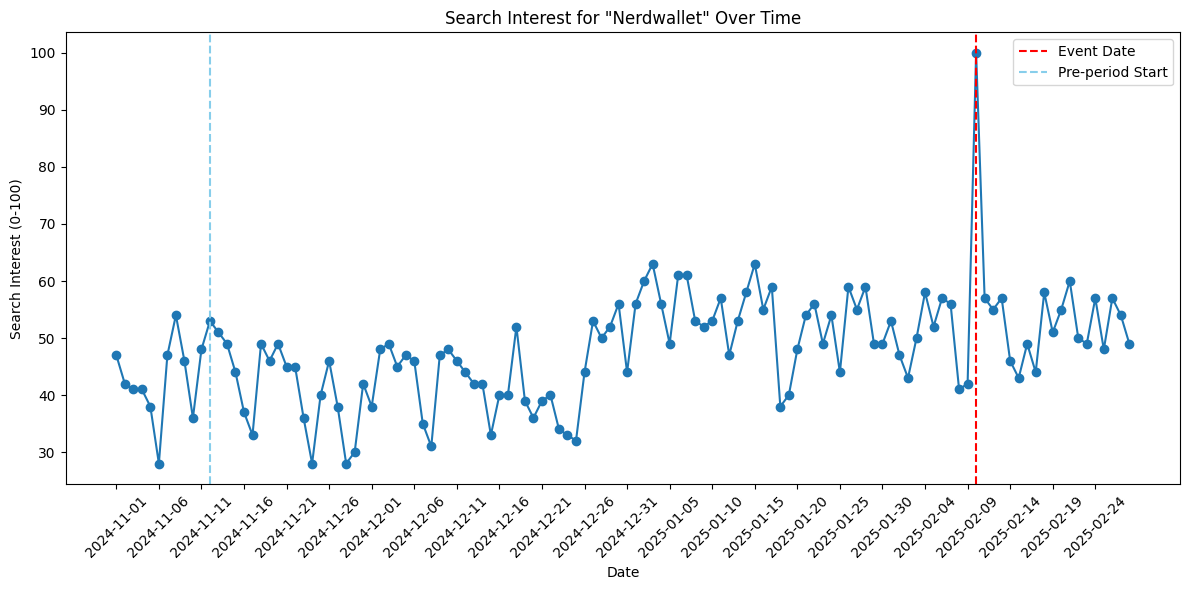

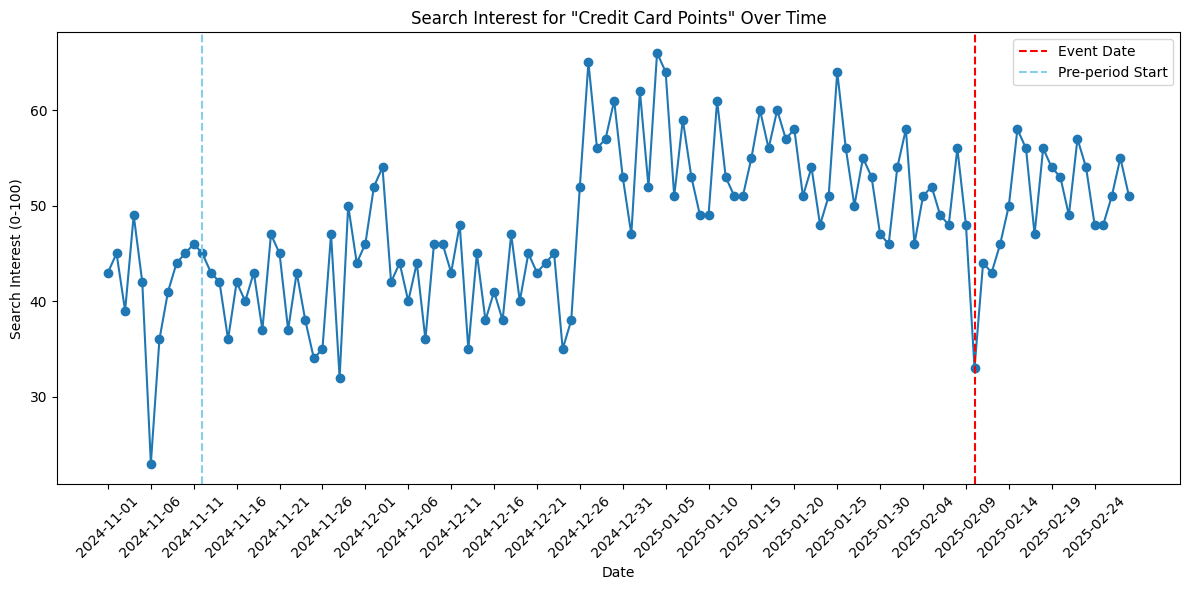

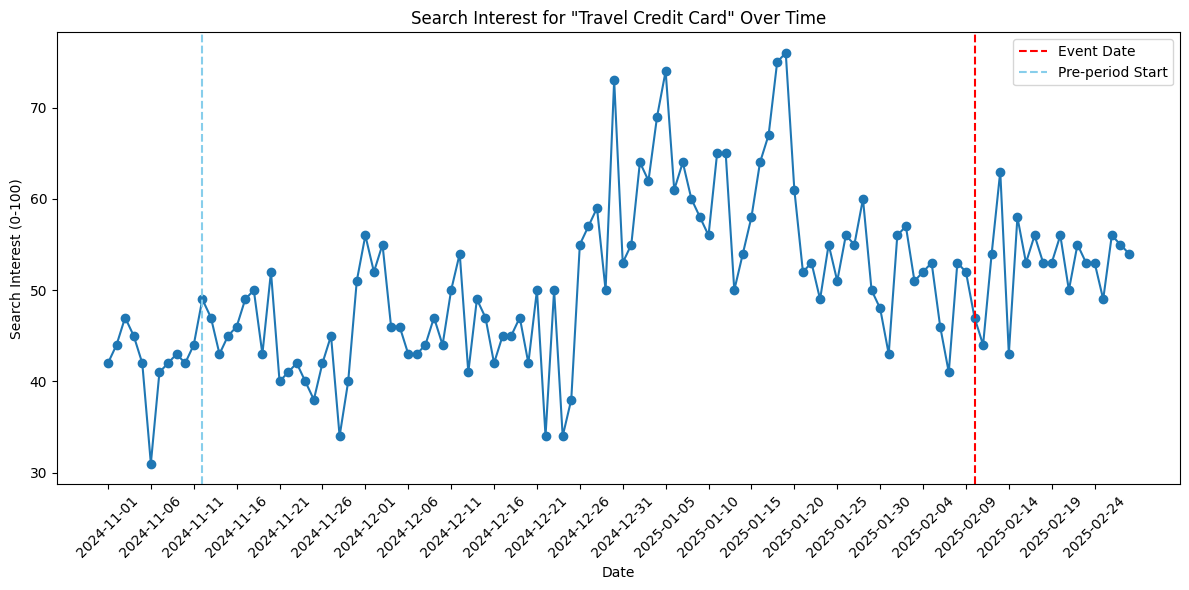

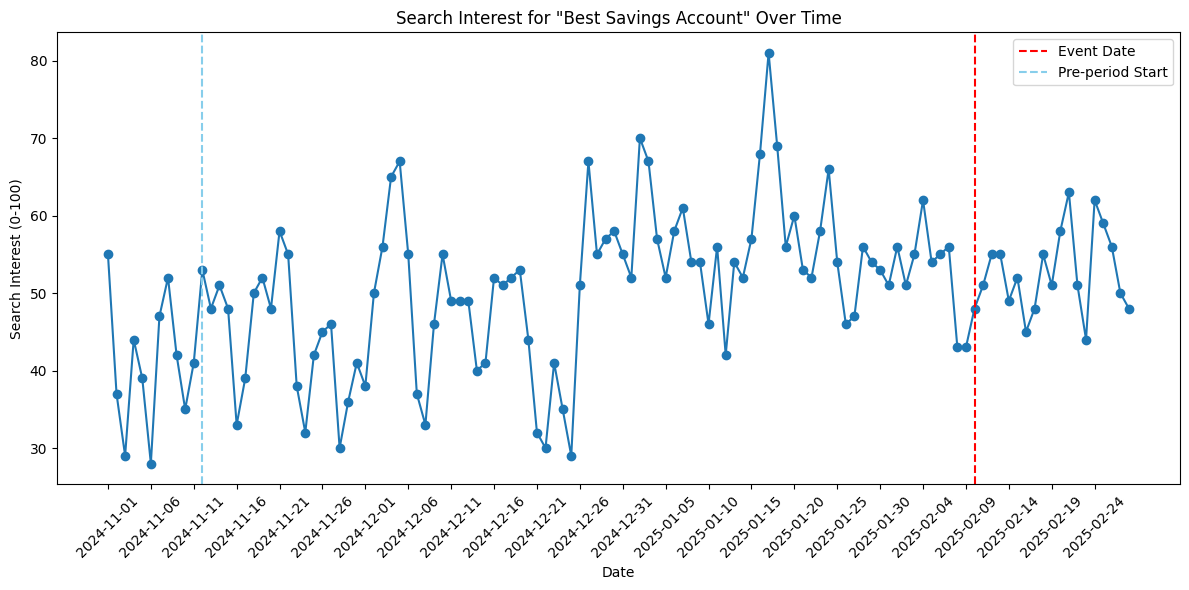

In [4]:
### nerdwallet timeseries plot
keyword_list = ['nerdwallet', 'credit_card_points', 'travel_credit_card', 'best_savings_account']
import matplotlib.pyplot as plt

for keyword in keyword_list:
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df[keyword], marker='o', linestyle='-')
    plt.title(f'Search Interest for "{keyword.replace("_", " ").title()}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Search Interest (0-100)')
    xticks = df['date'][::5]
    plt.xticks(ticks=xticks, labels=xticks, rotation=45)
    # Plot vertical lines for event and pre-period start
    plt.axvline(x=event_date.strftime('%Y-%m-%d'), color='red', linestyle='--', label='Event Date')
    plt.axvline(x=start_date.strftime('%Y-%m-%d'), color='skyblue', linestyle='--', label='Pre-period Start')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Interrupted Time Series (ITS) Modeling

In [5]:
# Fit an ITS model with level change only

# TO-DO: Create indicator for dates on or after treatment start 
event_date = pd.to_datetime(event_date)
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
df['date'] = pd.to_datetime(df['date'])
df['post'] = np.where(df['date']>=event_date, 1, 0)
df['trend'] = (pd.to_datetime(df['date']) - event_date).dt.days
df['trend:post'] = df['trend'] * df['post']

# TO-DO: Estimate an ITS model testing for a level change only 
subset_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

formula = 'nerdwallet ~ trend + post + trend:post'  
its_model = smf.ols(formula = formula, data=subset_df).fit()
print(its_model.summary())

                            OLS Regression Results                            
Dep. Variable:             nerdwallet   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     17.74
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           3.31e-09
Time:                        21:54:05   Log-Likelihood:                -341.62
No. Observations:                  98   AIC:                             691.2
Df Residuals:                      94   BIC:                             701.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.9338      1.715     31.447      0.0

In [6]:
control = its_model.params['Intercept'] + subset_df['trend'] * its_model.params['trend']
treatment = its_model.params['Intercept'] + subset_df['trend'] * its_model.params['trend'] + subset_df['post'] * its_model.params['post'] + subset_df['trend:post'] * its_model.params['trend:post']

Text(0, 0.5, 'Search Interest (0-100)')

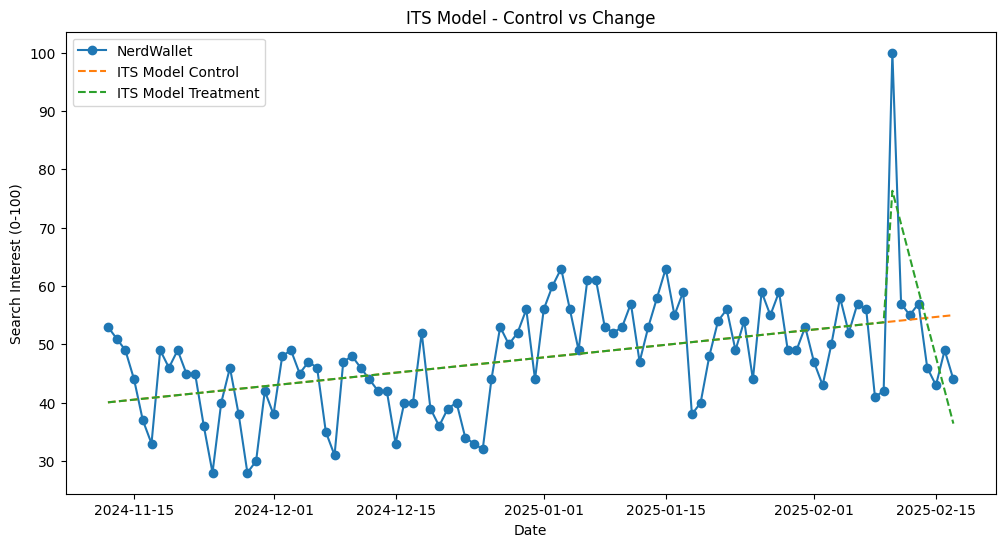

In [7]:
### plot the ITS model - control vs change
plt.figure(figsize=(12, 6))
plt.plot(subset_df['date'], subset_df['nerdwallet'], marker='o', linestyle='-', label='NerdWallet')
plt.plot(subset_df['date'], control, linestyle='--', label='ITS Model Control')
plt.plot(subset_df['date'], treatment, linestyle='--', label='ITS Model Treatment')
plt.title('ITS Model - Control vs Change')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Search Interest (0-100)')

### Testing 3, 7, and 14 day post period windows
- max post period window is 18 due to restrictions with the data set (we only have data thru feb 28th 2025)

In [8]:
post_period_window_list = [3, 7, 14]
for postperiod_length in post_period_window_list:
    end_date = event_date + pd.DateOffset(days=postperiod_length)
    subset_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()
    formula = 'nerdwallet ~ trend + post + trend:post'  
    its_model = smf.ols(formula = formula, data=subset_df).fit()
    print(f"Post-period length: {postperiod_length} days")
    print(its_model.summary())

Post-period length: 3 days
                            OLS Regression Results                            
Dep. Variable:             nerdwallet   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     20.59
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           3.04e-10
Time:                        21:54:05   Log-Likelihood:                -325.97
No. Observations:                  94   AIC:                             659.9
Df Residuals:                      90   BIC:                             670.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.9338    

__ITS Model Results:__
- treatment effect for ITS with a 7-day post-treatment window: +22 on the day of the event, and then -5.9 incremental effect on each day after (so ~16 on the day after the event, ~10 2 days after the event, etc.)
- I chose a post-treatment window of 1 week - this seems like a reasonable time period for seeing the effects of an ad being run, it's short enough to focus on the initial ad reaction, but long enough to capture residual effects and longer term 'rememberance' or notability of the ad - looking at the time series graphs, there's a _clear_ spike right on the event date when the ad(s) were run, but a serious regression to the initial trend - the 7 day window seems to be the most reasonable in capturing both of those effects.

In [9]:
event_date = pd.to_datetime('2025-02-10')
preperiod_length = 90
postperiod_length = 7

# Define the start and end dates for the pre and post event periods:
# Used to subset data prior to estimating the models 
start_date = event_date - pd.DateOffset(days=preperiod_length)
end_date = event_date + pd.DateOffset(days=postperiod_length)
subset_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

## Difference-in-Differences (DiD) Modeling

In [10]:
df_long = df.melt(id_vars=['date'], value_vars=['nerdwallet', 'credit_card_points', 'travel_credit_card', 'best_savings_account'], var_name='keyword', value_name='search_interest')

In [11]:
df_long['trend'] = (pd.to_datetime(df_long['date']) - event_date).dt.days
df_long['post'] = np.where(df_long['date']>=event_date, 1, 0)
df_long['treated'] = np.where(df_long['keyword'] == 'nerdwallet', 1, 0)

df_long_subset = df_long[(df_long['date'] >= start_date) & (df_long['date'] <= end_date)]

In [12]:
formula_did = 'search_interest ~ post + treated + post:treated'  
did_model = smf.ols(formula = formula_did, data=df_long_subset).fit()
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     4.353
Date:                Fri, 07 Nov 2025   Prob (F-statistic):            0.00495
Time:                        21:54:05   Log-Likelihood:                -1421.4
No. Observations:                 392   AIC:                             2851.
Df Residuals:                     388   BIC:                             2867.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       50.1370      0.556     90.176   

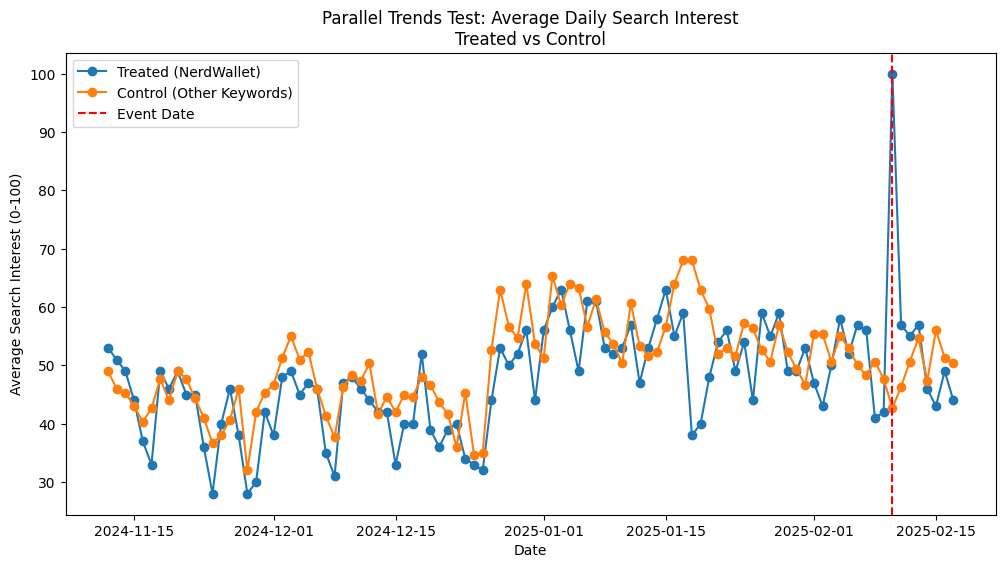

In [13]:
# Plot parallel trends: average search_interest over time for treated vs untreated, with event line

plt.figure(figsize=(12,6))

# Group by date and treated, then mean
avg_trends = df_long_subset.groupby(['date', 'treated'])['search_interest'].mean().reset_index()

# Plot for treated=1 (NerdWallet)
treated_trend = avg_trends[avg_trends['treated']==1]
plt.plot(treated_trend['date'], treated_trend['search_interest'], label='Treated (NerdWallet)', marker='o')

# Plot for treated=0 (control keywords)
control_trend = avg_trends[avg_trends['treated']==0]
plt.plot(control_trend['date'], control_trend['search_interest'], label='Control (Other Keywords)', marker='o')

# Vertical line at the event date
plt.axvline(event_date, color='red', linestyle='--', label='Event Date')

plt.xlabel('Date')
plt.ylabel('Average Search Interest (0-100)')
plt.title('Parallel Trends Test: Average Daily Search Interest\nTreated vs Control')
plt.legend()
plt.show()


In [14]:
df_long_subset['post_treated'] = df_long_subset['treated'] * df_long_subset['post']

/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_35730/1612479054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long_subset['post_treated'] = df_long_subset['treated'] * df_long_subset['post']


In [15]:
did_effect = df_long_subset['post_treated'] * did_model.params['post:treated']
print(f"Avg daily Effect: {did_model.params['post:treated']:.1f}")

Avg daily Effect: 9.7


__Diff-in-Diff Model Results:__
- treatment effect for Diff-in-Diff with a 7-day post-treatment window: +9.7, and it _is_ stat sig
- this is quite a bit of an increase over the ITS model, as we can see the control group takes a dip at the event date, which the ITS model does _not_ account for - so we see a larger treatment effect for diff-in-diff over ITS due to the additional information we're now incorporating about the control
- I chose a post-treatment window of 1 week - this seems like a reasonable time period for seeing the effects of an ad being run, it's short enough to focus on the initial ad reaction, but long enough to capture residual effects and longer term 'rememberance' or notability of the ad - looking at the time series graphs, there's a _clear_ spike right on the event date when the ad(s) were run, but a serious regression to the initial trend - the 7 day window seems to be the most reasonable in capturing both of those effects.

## Difference-in-Differences Modeling with Controls

In [16]:
df_long_subset['credit_card_points'] = np.where(df_long_subset['keyword'] == 'credit_card_points', 1, 0)
df_long_subset['travel_credit_card'] = np.where(df_long_subset['keyword'] == 'travel_credit_card', 1, 0)
df_long_subset['best_savings_account'] = np.where(df_long_subset['keyword'] == 'best_savings_account', 1, 0)

formula_did_w_controls = 'search_interest ~ post + C(keyword) + post:treated'  
did_model_w_controls = smf.ols(formula = formula_did_w_controls, data=df_long_subset).fit()
print(did_model_w_controls.summary())

                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     3.962
Date:                Fri, 07 Nov 2025   Prob (F-statistic):            0.00162
Time:                        21:54:05   Log-Likelihood:                -1418.1
No. Observations:                 392   AIC:                             2848.
Df Residuals:                     386   BIC:                             2872.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_35730/86373234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long_subset['credit_card_points'] = np.where(df_long_subset['keyword'] == 'credit_card_points', 1, 0)
/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_35730/86373234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long_subset['travel_credit_card'] = np.where(df_long_subset['keyword'] == 'travel_credit_card', 1, 0)
/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/i

__Diff-in-Diff with Control Model Results:__
- treatment effect for Diff-in-Diff with Control with a 7-day post-treatment window: +9.7, and it _is_ stat sig
- this is the same as the Diff-in-Diff model without the Control, which signals to me that the control signal was already being properly captured in the initial diff-in-diff model - the three control covariates aggregated work just as well as each covariate separated out
- I chose a post-treatment window of 1 week - this seems like a reasonable time period for seeing the effects of an ad being run, it's short enough to focus on the initial ad reaction, but long enough to capture residual effects and longer term 'rememberance' or notability of the ad - looking at the time series graphs, there's a _clear_ spike right on the event date when the ad(s) were run, but a serious regression to the initial trend - the 7 day window seems to be the most reasonable in capturing both of those effects.

## Event Study Modeling

In [17]:
# Create lead and lag groups from the previous single days
df_event = subset_df.copy()
df_event['days_to_event'] = df_event['trend']
df_event['lead_5_to_7'] = ((df_event['days_to_event'] >= -7) & (df_event['days_to_event'] <= -5)).astype(int)
df_event['lead_1_to_4'] = ((df_event['days_to_event'] >= -4) & (df_event['days_to_event'] <= -1)).astype(int)
df_event['event_day'] = (df_event['days_to_event'] == 0).astype(int)
df_event['lag_1_to_4'] = ((df_event['days_to_event'] >= 1) & (df_event['days_to_event'] <= 4)).astype(int)
df_event['lag_5_to_7'] = ((df_event['days_to_event'] >= 5) & (df_event['days_to_event'] <= 7)).astype(int)
event_study_formula = (
    "nerdwallet ~ credit_card_points + travel_credit_card + best_savings_account "
    "+ lead_5_to_7 + lead_1_to_4 + event_day + lag_1_to_4 + lag_5_to_7"
)

event_study_model_og = smf.ols(formula=event_study_formula, data=df_event).fit()
print(event_study_model_og.summary())

                            OLS Regression Results                            
Dep. Variable:             nerdwallet   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     23.86
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           3.95e-19
Time:                        21:54:05   Log-Likelihood:                -307.47
No. Observations:                  98   AIC:                             632.9
Df Residuals:                      89   BIC:                             656.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.4352 

In [18]:
print(f"Treatment Effect on day of event: {event_study_model_og.params['event_day']:.1f}")
print(f"Treatment Effect on lead 1-4 days: {event_study_model_og.params['lead_1_to_4']:.1f}")
print(f"Treatment Effect on lag 1-4 days: {event_study_model_og.params['lag_1_to_4']:.1f}")
print(f"Treatment Effect on lead 5-7 days: {event_study_model_og.params['lead_5_to_7']:.1f}")
print(f"Treatment Effect on lag 5-7 days: {event_study_model_og.params['lag_5_to_7']:.1f}")


Treatment Effect on day of event: 58.2
Treatment Effect on lead 1-4 days: 2.8
Treatment Effect on lag 1-4 days: 6.8
Treatment Effect on lead 5-7 days: 3.4
Treatment Effect on lag 5-7 days: -1.6


__Event Study Model Results:__
- treatment effect for Event Study Model: on the day of the event (the super bowl!) we see a _huge_ treatment effect of 58.2! Which quickly regresses to 6.8, and finally turns negative by the end of the week to -1.6.
- this is able to capture the non-constant treatment effects across time - and there's clearly a huge spike on the day of the super bowl that quickly diminishes to much smaller effects, and surprisingly even turns negative towards the end of the week after the super bowl.

#### Event Study Modeling with Psuedo Model Permutations

In [19]:
preperiod_length = 60
postperiod_length = 7

days_that_can_be_shifted = (event_date - df['date'].min()).days - preperiod_length
print(days_that_can_be_shifted)

placebo_treatment_effects_list_event_day = []
placebo_treatment_effects_list_lag_1_to_4 = []
placebo_treatment_effects_list_lag_5_to_7 = []

for date_index in range(postperiod_length+1, days_that_can_be_shifted):
    event_date_placebo = event_date - pd.Timedelta(days=date_index)
    model_start_date_placebo = event_date_placebo - pd.Timedelta(days=preperiod_length)
    model_end_date_placebo = event_date_placebo + pd.Timedelta(days=postperiod_length)

    subset = df[(df['date']>=model_start_date_placebo) & (df['date']<model_end_date_placebo)].copy()

    # Create days_to_event as the number of days before or after the event_date_placebo
    subset['days_to_event'] = (subset['date'] - event_date_placebo).dt.days
    subset['lead_5_to_7'] = ((subset['days_to_event'] >= -7) & (subset['days_to_event'] <= -5)).astype(int)
    subset['lead_1_to_4'] = ((subset['days_to_event'] >= -4) & (subset['days_to_event'] <= -1)).astype(int)
    subset['event_day'] = (subset['days_to_event'] == 0).astype(int)
    subset['lag_1_to_4'] = ((subset['days_to_event'] >= 1) & (subset['days_to_event'] <= 4)).astype(int)
    subset['lag_5_to_7'] = ((subset['days_to_event'] >= 5) & (subset['days_to_event'] <= 7)).astype(int)
    
    event_study_formula = (
        "nerdwallet ~ credit_card_points + travel_credit_card + best_savings_account "
        "+ lead_5_to_7 + lead_1_to_4 + event_day + lag_1_to_4 + lag_5_to_7"
    )

    event_study_model = smf.ols(formula=event_study_formula, data=subset).fit()
    
    placebo_treatment_effects_list_event_day.append(event_study_model.params['event_day'])
    placebo_treatment_effects_list_lag_1_to_4.append(event_study_model.params['lag_1_to_4'])
    placebo_treatment_effects_list_lag_5_to_7.append(event_study_model.params['lag_5_to_7'])    


41


In [20]:
print(f"Mean Placebo Effect: {np.mean(placebo_treatment_effects_list_event_day)}")
print(f"Mean Placebo Effect: {np.mean(placebo_treatment_effects_list_lag_1_to_4)}")
print(f"Mean Placebo Effect: {np.mean(placebo_treatment_effects_list_lag_5_to_7)}")

Mean Placebo Effect: 2.201529265972278
Mean Placebo Effect: 2.2558634690679815
Mean Placebo Effect: 2.560307048444511


In [21]:
rmse = (np.mean(np.square(placebo_treatment_effects_list_event_day)))**0.5
print(f"RMSE: {rmse}")
rmse_lag_1_to_4 = (np.mean(np.square(placebo_treatment_effects_list_lag_1_to_4)))**0.5
print(f"RMSE: {rmse_lag_1_to_4}")
rmse_lag_5_to_7 = (np.mean(np.square(placebo_treatment_effects_list_lag_5_to_7)))**0.5
print(f"RMSE: {rmse_lag_5_to_7}")

RMSE: 8.02649632159115
RMSE: 5.567896538498228
RMSE: 7.0531077880356365


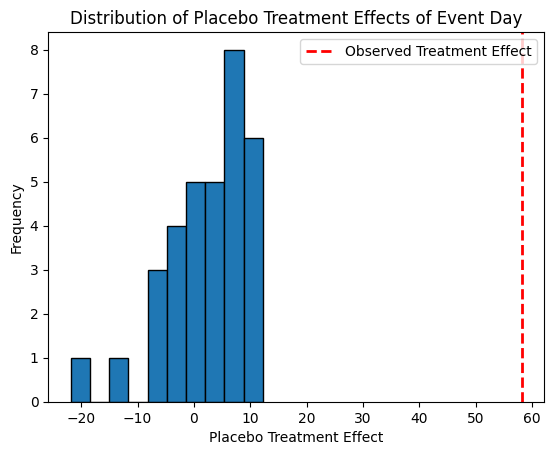

In [22]:
plt.hist(placebo_treatment_effects_list_event_day, bins=10, edgecolor='black')
plt.axvline(x=event_study_model_og.params['event_day'], color='red', linestyle='dashed', linewidth=2, label='Observed Treatment Effect')
plt.legend()
plt.xlabel('Placebo Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Placebo Treatment Effects of Event Day')
plt.show()


In [23]:
# Test whether the observed treatment effect (7.45) is statistically significantly different from the mean placebo effect (1.87)
from scipy.stats import ttest_1samp

observed_treatment_effect = event_study_model_og.params['event_day']
mean_placebo_effect = np.mean(placebo_treatment_effects_list_event_day)
std_placebo_effect = np.std(placebo_treatment_effects_list_event_day, ddof=1)
n_placebo = len(placebo_treatment_effects_list_event_day)

# 1. Compute a one-sample t-test: is observed_treatment_effect different from the placebo distribution mean?
t_stat, p_value = ttest_1samp(placebo_treatment_effects_list_event_day, observed_treatment_effect)

print(f"Mean Placebo Effect: {mean_placebo_effect:.2f}")
print(f"Observed Treatment Effect: {observed_treatment_effect:.2f}")
print(f"t-stat: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The observed treatment effect is statistically significantly different from the placebo distribution (p < 0.05).")
else:
    print("The observed treatment effect is NOT statistically significantly different from the placebo distribution (p >= 0.05).")


Mean Placebo Effect: 2.20
Observed Treatment Effect: 58.18
t-stat: -41.03
p-value: 0.0000
The observed treatment effect is statistically significantly different from the placebo distribution (p < 0.05).


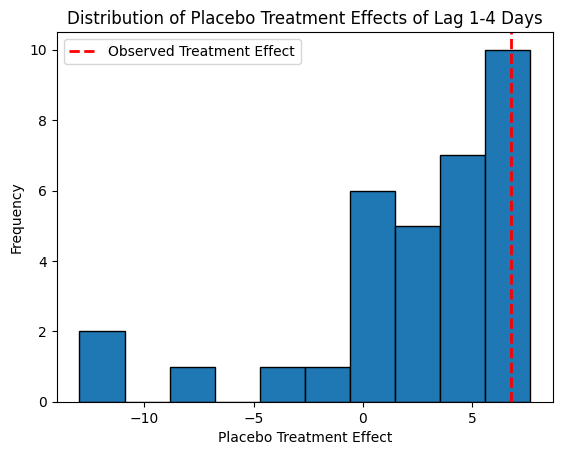

In [24]:
plt.hist(placebo_treatment_effects_list_lag_1_to_4, bins=10, edgecolor='black')
plt.axvline(x=event_study_model_og.params['lag_1_to_4'], color='red', linestyle='dashed', linewidth=2, label='Observed Treatment Effect')
plt.legend()
plt.xlabel('Placebo Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Placebo Treatment Effects of Lag 1-4 Days')
plt.show()


In [25]:
observed_treatment_effect = event_study_model_og.params['lag_1_to_4']
mean_placebo_effect = np.mean(placebo_treatment_effects_list_lag_1_to_4)
std_placebo_effect = np.std(placebo_treatment_effects_list_lag_1_to_4, ddof=1)
n_placebo = len(placebo_treatment_effects_list_lag_1_to_4)

# 1. Compute a one-sample t-test: is observed_treatment_effect different from the placebo distribution mean?
t_stat, p_value = ttest_1samp(placebo_treatment_effects_list_lag_1_to_4, observed_treatment_effect)

print(f"Mean Placebo Effect: {mean_placebo_effect:.2f}")
print(f"Observed Treatment Effect: {observed_treatment_effect:.2f}")
print(f"t-stat: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The observed treatment effect is statistically significantly different from the placebo distribution (p < 0.05).")
else:
    print("The observed treatment effect is NOT statistically significantly different from the placebo distribution (p >= 0.05).")


Mean Placebo Effect: 2.26
Observed Treatment Effect: 6.81
t-stat: -5.06
p-value: 0.0000
The observed treatment effect is statistically significantly different from the placebo distribution (p < 0.05).


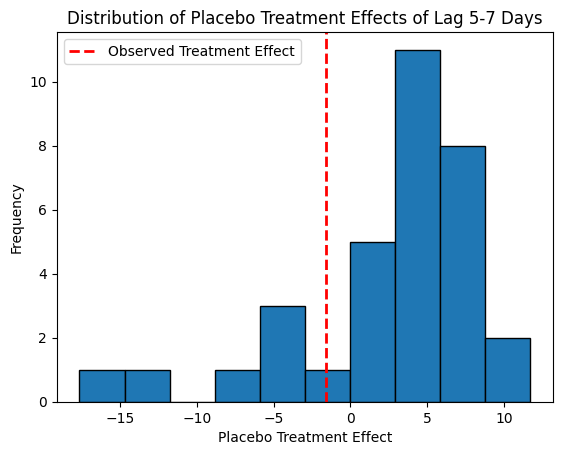

In [26]:
plt.hist(placebo_treatment_effects_list_lag_5_to_7, bins=10, edgecolor='black')
plt.axvline(x=event_study_model_og.params['lag_5_to_7'], color='red', linestyle='dashed', linewidth=2, label='Observed Treatment Effect')
plt.legend()
plt.xlabel('Placebo Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Placebo Treatment Effects of Lag 5-7 Days')
plt.show()


In [27]:
observed_treatment_effect = event_study_model_og.params['lag_5_to_7']
mean_placebo_effect = np.mean(placebo_treatment_effects_list_lag_5_to_7)
std_placebo_effect = np.std(placebo_treatment_effects_list_lag_5_to_7, ddof=1)
n_placebo = len(placebo_treatment_effects_list_lag_5_to_7)

# 1. Compute a one-sample t-test: is observed_treatment_effect different from the placebo distribution mean?
t_stat, p_value = ttest_1samp(placebo_treatment_effects_list_lag_5_to_7, observed_treatment_effect)

print(f"Mean Placebo Effect: {mean_placebo_effect:.2f}")
print(f"Observed Treatment Effect: {observed_treatment_effect:.2f}")
print(f"t-stat: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The observed treatment effect is statistically significantly different from the placebo distribution (p < 0.05).")
else:
    print("The observed treatment effect is NOT statistically significantly different from the placebo distribution (p >= 0.05).")


Mean Placebo Effect: 2.56
Observed Treatment Effect: -1.58
t-stat: 3.56
p-value: 0.0012
The observed treatment effect is statistically significantly different from the placebo distribution (p < 0.05).


__Event Study Model Placebo Results:__
- the event treatment effect on the event day is _58_, which is significantly different than the average treatment effect from the 'pseudo' event days of 2 - the lag on 1-4 days is down to 6.8, which is still higher than the 'pseudo' lag effect on days 1-4 after the 'pseudo' event day of 2 - however, the 5-7 day lag effect of -1.58 is _still_ significantly different, but in the opposite direction! on the non-event 'pseudo' events, we see a lagged effect 5-7 days after of 2.56, but this is significantly lower, which is interesting - this is certainly new information not being captured by the other models which is very useful information!

## Estimating a Synthetic Control using Lasso

In [28]:
treated_term = "nerdwallet"
control_terms = ['credit_card_points', 'travel_credit_card', 'best_savings_account']

preperiod = df[(df['date']<event_date) & (df['date']>=start_date)].copy()

# Initialize Lasso model with a regularization parameter (in the future, you may want to tune this parameter)
lasso_model = LassoCV(cv=5, random_state=42)

# TO-DO: Fit the lasso model, save and print the coefficients
lasso_model.fit(preperiod[control_terms], preperiod[treated_term])
lasso_coefficients = lasso_model.coef_
lasso_intercept = lasso_model.intercept_
lasso_alpha = lasso_model.alpha_

print("Best alpha:", lasso_alpha)
print("Intercept:", lasso_intercept)
print("Coefficients:", lasso_coefficients)

Best alpha: 2.4079860992862865
Intercept: 11.16766504865818
Coefficients: [0.24430296 0.         0.47180216]


In [29]:
pre_post_df = df[(df['date']>=start_date) & (df['date']<=end_date)].copy()
pre_post_df["synthetic_control"] = pre_post_df[control_terms].dot(lasso_coefficients) + lasso_intercept

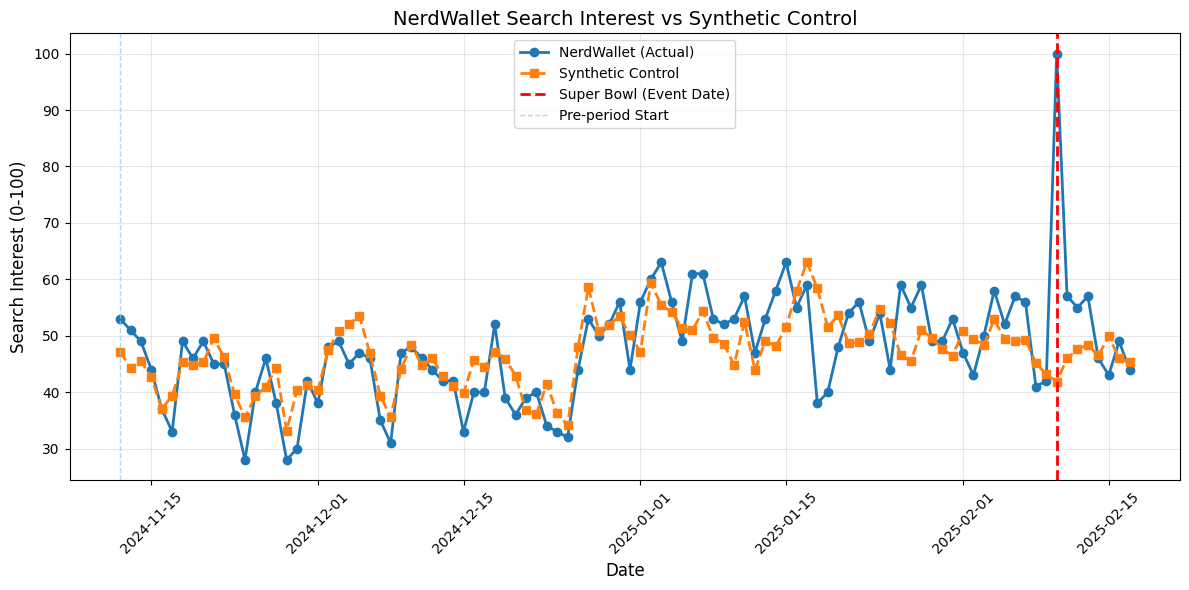

In [30]:
plt.figure(figsize=(12, 6))

# Plot actual NerdWallet data
plt.plot(pre_post_df['date'], pre_post_df['nerdwallet'], marker='o', linestyle='-', label='NerdWallet (Actual)', linewidth=2)

# Plot synthetic control
plt.plot(pre_post_df['date'], pre_post_df['synthetic_control'], marker='s', linestyle='--', label='Synthetic Control', linewidth=2)

# Add vertical line for event date
plt.axvline(x=event_date, color='red', linestyle='--', linewidth=2, label='Super Bowl (Event Date)')

# Add vertical line for pre-period start
plt.axvline(x=start_date, color='skyblue', linestyle='--', linewidth=1, alpha=0.7, label='Pre-period Start')

# Labels and formatting
plt.title('NerdWallet Search Interest vs Synthetic Control', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Interest (0-100)', fontsize=12)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

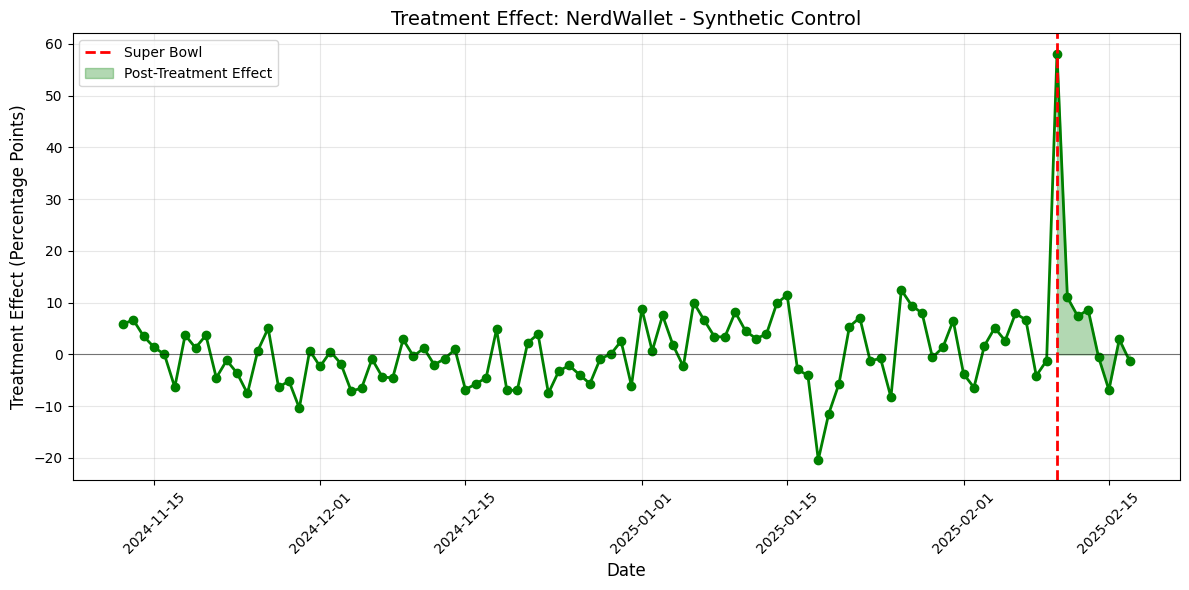

In [31]:
# Calculate the treatment effect (actual - synthetic)
pre_post_df['treatment_effect'] = pre_post_df['nerdwallet'] - pre_post_df['synthetic_control']

plt.figure(figsize=(12, 6))
plt.plot(pre_post_df['date'], pre_post_df['treatment_effect'], marker='o', linestyle='-', linewidth=2, color='green')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
plt.axvline(x=event_date, color='red', linestyle='--', linewidth=2, label='Super Bowl')
plt.fill_between(pre_post_df['date'], 0, pre_post_df['treatment_effect'], 
                 where=(pre_post_df['post']==1), 
                 alpha=0.3, color='green', label='Post-Treatment Effect')
plt.title('Treatment Effect: NerdWallet - Synthetic Control', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Treatment Effect (Percentage Points)', fontsize=12)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
# TO-DO: Calculate the average monthly treatment effect in the post-treatment period: 
# How does this compare to the value the treated region would have had without the intervention?  
post_period = pre_post_df[pre_post_df['date']>=event_date]
print('average daily treatment effect in post-treatment period:', post_period["treatment_effect"].mean())

average daily treatment effect in post-treatment period: 9.927524121824206


In [33]:
# Print the treatment_effect by day in the post-treatment period
post_period = pre_post_df[pre_post_df['post']==1]
for idx, row in post_period.iterrows():
    print(f"treatment effect on {row['date'].strftime('%Y-%m-%d')}: {row['treatment_effect']}")

treatment effect on 2025-02-10: 58.12383357316394
treatment effect on 2025-02-11: 11.021094524558336
treatment effect on 2025-02-12: 7.378188846177565
treatment effect on 2025-02-13: 8.645279963670326
treatment effect on 2025-02-14: -0.5011189208478868
treatment effect on 2025-02-15: -6.870949086946254
treatment effect on 2025-02-16: 2.9202719533541526
treatment effect on 2025-02-17: -1.2964078785365132


__Synthetic Control (with Lasso) Results:__
- the daily treatment effect is 9.9 for the post period 7 day window - this is slightly higher than what we found in the event study model and the diff-in-diff models, but the synthetic control also lets us see the effects vary by day post event, very similar to what we saw in the event study model - we see a treatment effect of 58 on the super bowl day, 11 the day after, but by day 5, we see a ~-7 decrease!
- I chose a post-treatment window of 1 week for the same reasons mentioned above

## Optimizing with Cross-Validation

In [34]:
from sklearn.preprocessing import StandardScaler

# 1. Define your control terms (donor pool)
control_terms = ['credit_card_points', 'travel_credit_card', 'best_savings_account']

# 2. Filter to PRE-TREATMENT period only (this is crucial!)
pre_treatment_df = df[df['date'] < event_date].copy()

# 3. Prepare X (controls) and y (treated unit) for pre-treatment period
X_pre = pre_treatment_df[control_terms]
y_pre = pre_treatment_df['nerdwallet']

# 4. Standardize the features
scaler = StandardScaler()
X_pre_scaled = scaler.fit_transform(X_pre)

# 5. Use LassoCV to find optimal alpha with cross-validation
# - cv=5 means 5-fold cross-validation
# - alphas: list of alpha values to try (you can customize this)
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 2, 100),  # 100 alpha values from 0.0001 to 100
    cv=5,                             # 5-fold cross-validation
    random_state=42,
    max_iter=10000
)

# 6. Fit on pre-treatment data
lasso_cv.fit(X_pre_scaled, y_pre)

# 7. Get optimal alpha
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha}")

# 8. Get coefficients and intercept
lasso_coefficients = lasso_cv.coef_
lasso_intercept = lasso_cv.intercept_

print(f"\nSynthetic Control Weights:")
for term, coef in zip(control_terms, lasso_coefficients):
    print(f"  {term}: {coef:.4f}")

# 9. Create synthetic control for FULL period (pre + post)
X_full = df[control_terms]
X_full_scaled = scaler.transform(X_full)  # Use same scaler from pre-period
df['synthetic_control'] = lasso_cv.predict(X_full_scaled)




Optimal alpha: 0.32745491628777285

Synthetic Control Weights:
  credit_card_points: 1.8514
  travel_credit_card: 0.0000
  best_savings_account: 4.6488


## If necessary, net out pre-period differences using a Difference-in-Differences Model

#### Note: In some cases, the synthetic control may have a poor pre-period fit, or a different pre-treatment average outcome than the treated group. In those cases, you may wish to net out the pre-period differences using a DiD model.  If the pre-period fit is very close, then this step is not necessary; simply compare post-treatment outcomes. 

#### Important: The DiD model underestimates the standard error for synthetic control models and should NOT be used to determine statistical significance. The permutation tests below are for statistical significance and confidence intervals

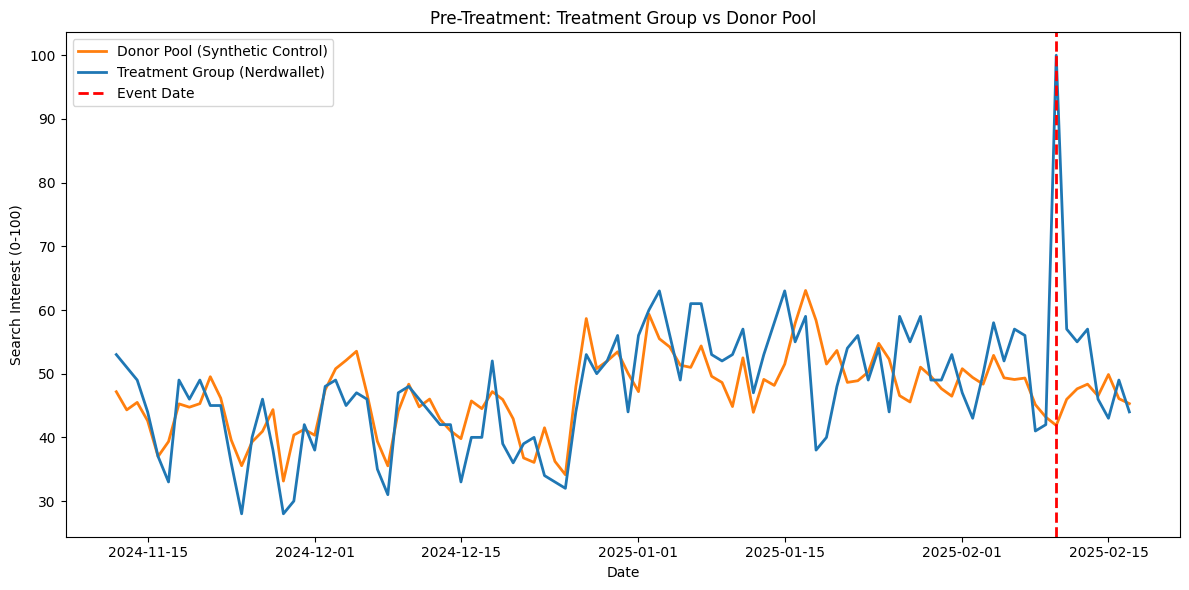

In [35]:
import matplotlib.pyplot as plt

# Plot donor pool (synthetic control) vs treatment group (Nerdwallet)
plt.figure(figsize=(12, 6))

# Plot donor pool: sum of weighted controls (the synthetic control)
plt.plot(pre_post_df['date'], pre_post_df['synthetic_control'], label='Donor Pool (Synthetic Control)', color='tab:orange', linewidth=2)

# Plot treatment group (Nerdwallet)
plt.plot(pre_post_df['date'], pre_post_df['nerdwallet'], label='Treatment Group (Nerdwallet)', color='tab:blue', linewidth=2)

plt.axvline(event_date, color='red', linestyle='--', linewidth=2, label='Event Date')


plt.xlabel('Date')
plt.ylabel('Search Interest (0-100)')
plt.title('Pre-Treatment: Treatment Group vs Donor Pool')
plt.legend()
plt.tight_layout()
plt.show()



In [36]:
# Check pre-treatment fit quality
pre_treatment_df_check = df[df['date'] < event_date]
mse_pre = np.mean((pre_treatment_df_check['nerdwallet'] - pre_treatment_df_check['synthetic_control'])**2)
print(f"\nPre-treatment MSE: {mse_pre:.2f}")

mae_pre = np.mean(np.abs(pre_treatment_df_check['nerdwallet'] - pre_treatment_df_check['synthetic_control']))
print(f"\nPre-treatment MAE: {mae_pre:.2f}")

pct_mae_of_avg = (mae_pre / pre_treatment_df_check['nerdwallet'].mean()) * 100
print(f"\nPre-treatment MAE as % of NerdWallet average: {pct_mae_of_avg:.2f}%")


Pre-treatment MSE: 31.88

Pre-treatment MAE: 4.58

Pre-treatment MAE as % of NerdWallet average: 9.87%


- conclusion: don't need DiD modeling with synthetic control, as the MSE / MAE is relatively small pre-treatment, meaning that the donor pool creates a pretty good pre-treatment fit of nerdwallet, signifying that it also makes a pretty good post-treatment proxy for what nerdwallet _wouldve_ looked like had it not gotten the super bowl ad
- you can also see that there isn't a big difference between the control and treatment time series lines in the pre event time period

## Permutation Testing

### Geoff Notes:

- In-Space Placebos

- This is what Abadie et al. (the original synthetic control authors) recommend:
- Concept: Pretend each control unit was treated instead, create synthetic controls for them, and see if their "fake" treatment effects are as large as your real one.

In [37]:
control_terms = ['credit_card_points', 'travel_credit_card', 'best_savings_account']
placebo_effects = []

all_units = ['nerdwallet'] + control_terms

pre_df = pre_post_df[pre_post_df['date'] < event_date].copy()
post_df = pre_post_df[pre_post_df['date'] >= event_date].copy()

for treated_unit in all_units:
    # Donor pool: all other units
    donor_pool = [u for u in all_units if u != treated_unit]
    
    X_pre = pre_df[donor_pool]
    y_pre = pre_df[treated_unit]
    
    scaler = StandardScaler()
    X_pre_scaled = scaler.fit_transform(X_pre)
    
    lasso_cv = LassoCV(
        alphas=np.logspace(-4, 2, 100),  # 100 alpha values from 0.0001 to 100
        cv=5,                             # 5-fold cross-validation
        random_state=42,
        max_iter=10000
    )
    lasso_cv.fit(X_pre_scaled, y_pre)
    
    # Predict on post-treatment data
    X_post = post_df[donor_pool]
    X_post_scaled = scaler.transform(X_post)
    post_df[f'synthetic_{treated_unit}'] = lasso_cv.predict(X_post_scaled)

    # Calculate treatment effect in post-period
    post_effect = (post_df[treated_unit] - post_df[f'synthetic_{treated_unit}']).mean()
    placebo_effects.append({
        'unit': treated_unit,
        'effect': post_effect,
        'is_treated': treated_unit == 'nerdwallet'
    })

# Create results dataframe
placebo_df = pd.DataFrame(placebo_effects)
print(placebo_df)

    
        

                   unit    effect  is_treated
0            nerdwallet  9.916337        True
1    credit_card_points -3.145784       False
2    travel_credit_card  1.979915       False
3  best_savings_account -6.498541       False


In [39]:
# Test if the nerdwallet effect is statistically different from the placebo/control effects

from scipy.stats import ttest_ind
import scipy.stats as stats

treated_effect = placebo_df[placebo_df['unit'] == 'nerdwallet']['effect'].values
placebo_effects_only = placebo_df[placebo_df['unit'] != 'nerdwallet']['effect'].values

# t-test: is nerdwallet effect different from control units?
x = np.array(placebo_effects_only)
mu0 = treated_effect

t_stat, p_value = stats.ttest_1samp(x, popmean=mu0)

print(f"Treated (nerdwallet) effect: {treated_effect[0]:.4f}")
print(f"Mean placebo effect: {placebo_effects_only.mean():.4f}")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The nerdwallet effect is statistically significantly different from the placebo/control effects (p < 0.05).")
else:
    print("The nerdwallet effect is NOT statistically significantly different from the placebo/control effects (p >= 0.05).")


Treated (nerdwallet) effect: 9.9163
Mean placebo effect: -2.5548
t-statistic: -5.059, p-value: 0.0369
The nerdwallet effect is statistically significantly different from the placebo/control effects (p < 0.05).


__Conclusion:__
- the results for an 'in place' test _are_ stat sig, but the donor pool is small (3) - we'll also rely on an 'in-time' placebo / permutation test below, where you permutate between different 'placebo' event dates in the pre-period, similar in how we did with the event model study, in order to build a larger distribution

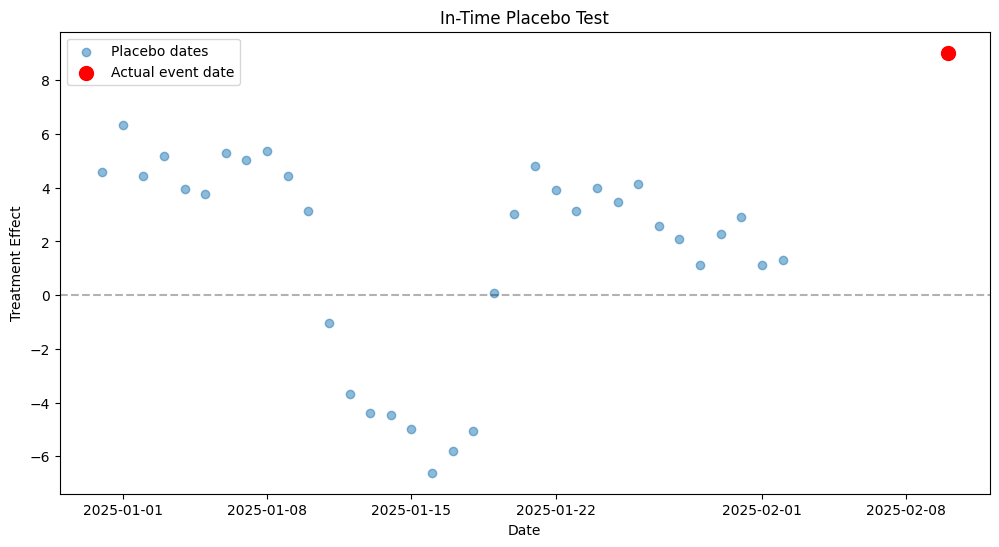

Event treatment effect: 9.023582389353471


In [41]:
placebo_results = []
control_terms = ['credit_card_points', 'travel_credit_card', 'best_savings_account']

pre_period_window = 60
post_period_window = 7

placebo_dates = pd.date_range(
    start=df['date'].min()+pd.DateOffset(days=pre_period_window),  # Start after some pre-period
    end=event_date - pd.DateOffset(days=post_period_window) - pd.DateOffset(days=1),      # End before real event
    freq='1D'  # Daily intervals
)

for placebo_date in placebo_dates:
    # 1. Filter to PRE-TREATMENT period only (this is crucial!)
    pre_treatment_df = df[(df['date'] < placebo_date) & (df['date'] >= (placebo_date - pd.DateOffset(days=pre_period_window)))].copy()
    post_treatment_df = df[(df['date'] >= placebo_date) & (df['date'] <= (placebo_date + pd.DateOffset(days=post_period_window)))].copy()

    # 2. Prepare X (controls) and y (treated unit) for pre-treatment period
    X_pre = pre_treatment_df[control_terms]
    y_pre = pre_treatment_df['nerdwallet']

    # 3. Standardize the features
    scaler = StandardScaler()
    X_pre_scaled = scaler.fit_transform(X_pre)

    # 4. Use LassoCV to find optimal alpha with cross-validation
    # - cv=5 means 5-fold cross-validation
    # - alphas: list of alpha values to try (you can customize this)
    lasso_cv = LassoCV(
        alphas=np.logspace(-4, 2, 100),  # 100 alpha values from 0.0001 to 100
        cv=5,                             # 5-fold cross-validation
        random_state=42,
        max_iter=10000
    )

    # 5. Fit on pre-treatment data
    lasso_cv.fit(X_pre_scaled, y_pre)

    # 6. Get optimal alpha
    optimal_alpha = lasso_cv.alpha_

    # 7. Get coefficients and intercept
    lasso_coefficients = lasso_cv.coef_
    lasso_intercept = lasso_cv.intercept_

    # 8. Create synthetic control for post-treatment period
    X_post = post_treatment_df[control_terms]
    X_post_scaled = scaler.transform(X_post)  # Use same scaler from pre-period
    post_treatment_df['synthetic_control'] = lasso_cv.predict(X_post_scaled)
    
    # Calculate "treatment effect" for this fake date
    placebo_effect = (post_treatment_df['nerdwallet'] - post_treatment_df['synthetic_control']).mean()
    
    placebo_results.append({
        'placebo_date': placebo_date,
        'effect': placebo_effect
    })

placebo_time_df = pd.DataFrame(placebo_results)

# Add actual event result as a row in placebo_time_df
actual_pre_treatment_df = df[(df['date'] < event_date) & (df['date'] >= (event_date - pd.DateOffset(days=pre_period_window)))].copy()
actual_post_treatment_df = df[(df['date'] >= event_date) & (df['date'] <= (event_date + pd.DateOffset(days=post_period_window)))].copy()

X_pre_actual = actual_pre_treatment_df[control_terms]
y_pre_actual = actual_pre_treatment_df['nerdwallet']

scaler_actual = StandardScaler()
X_pre_actual_scaled = scaler_actual.fit_transform(X_pre_actual)

lasso_cv_actual = LassoCV(
    alphas=np.logspace(-4, 2, 100),
    cv=5,
    random_state=42,
    max_iter=10000
)
lasso_cv_actual.fit(X_pre_actual_scaled, y_pre_actual)

X_post_actual = actual_post_treatment_df[control_terms]
X_post_actual_scaled = scaler_actual.transform(X_post_actual)
actual_post_treatment_df['synthetic_control'] = lasso_cv_actual.predict(X_post_actual_scaled)

actual_effect = (actual_post_treatment_df['nerdwallet'] - actual_post_treatment_df['synthetic_control']).mean()

# Add the actual result to placebo_time_df
placebo_time_df = placebo_time_df.copy()  # to avoid SettingWithCopyWarning
placebo_time_df['is_actual'] = False
placebo_time_df = pd.concat([
    placebo_time_df,
    pd.DataFrame([{
        'placebo_date': event_date,
        'effect': actual_effect,
        'is_actual': True
    }])
], ignore_index=True)

placebo_time_df['is_actual'] = placebo_time_df['is_actual'].fillna(False)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(placebo_time_df[~placebo_time_df['is_actual']]['placebo_date'], 
           placebo_time_df[~placebo_time_df['is_actual']]['effect'],
           alpha=0.5, label='Placebo dates')
plt.scatter(placebo_time_df[placebo_time_df['is_actual']]['placebo_date'],
           placebo_time_df[placebo_time_df['is_actual']]['effect'],
           color='red', s=100, label='Actual event date', zorder=5)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Treatment Effect')
plt.title('In-Time Placebo Test')
plt.legend()
plt.show()

print("Event treatment effect:", actual_effect)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


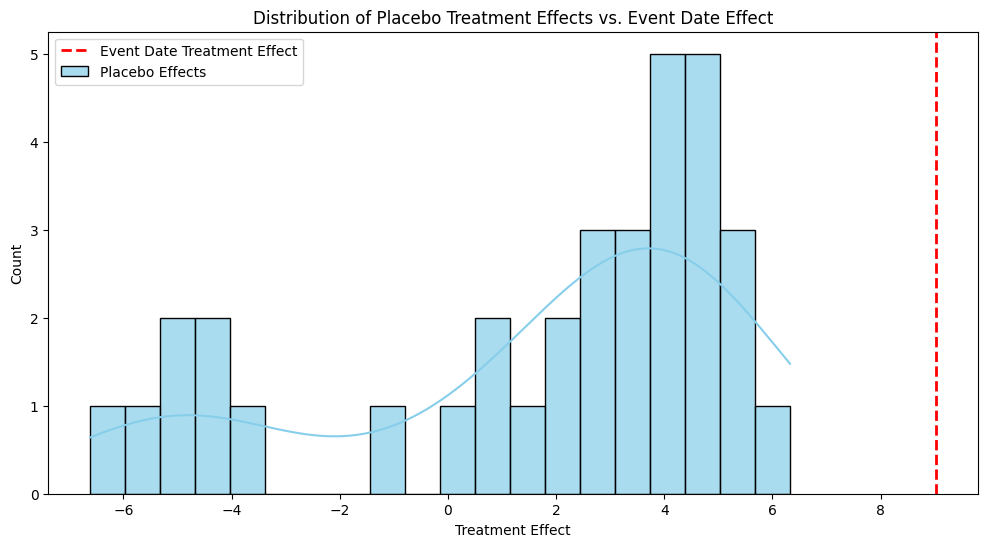

In [42]:
import seaborn as sns

# Plot the distribution of placebo treatment effects
plt.figure(figsize=(12, 6))
sns.histplot(placebo_time_df[~placebo_time_df['is_actual']]['effect'], bins=20, kde=True, color='skyblue', label='Placebo Effects', alpha=0.7)

# Overlay the actual treatment effect
actual_effect_value = placebo_time_df[placebo_time_df['is_actual']]['effect'].values[0]
plt.axvline(actual_effect_value, color='red', linewidth=2, linestyle='--', label='Event Date Treatment Effect')

plt.xlabel('Treatment Effect')
plt.ylabel('Count')
plt.title('Distribution of Placebo Treatment Effects vs. Event Date Effect')
plt.legend()
plt.show()


In [44]:
# Extract the actual event date effect
actual_effect = placebo_time_df[placebo_time_df['is_actual']==True]['effect'].values[0]

# Extract placebo effects
placebo_effects = placebo_time_df[~placebo_time_df['is_actual']==True]['effect'].values

average_placebo_effect = np.mean(placebo_effects)

x = np.array(placebo_effects)
mu0 = actual_effect

t_stat, p_value = stats.ttest_1samp(x, popmean=mu0)
print(t_stat, p_value)

print('average placebo effect:', average_placebo_effect)
print('actual effect:', actual_effect)


-11.39725600016864 5.550657186292114e-13
average placebo effect: 1.6264273610646884
actual effect: 9.023582389353471


__Conclusion:__
- the results for an 'in-time' test _is_ stat sig, and shows that the event treatment effect is stat sig - I had to reduce the period window down to 60 days in order to get the number of observations up to a reasonable to degree to build a sufficient distribution function - the effect is a bit lower (9 instead of 9.9 found earlier) but still close despite the smaller window size

## Final Model Selection and Rationale

__Final Model:__ 
I'm choosing **synthetic control** as the final model for the following reasons:
1. it provides a flexible weighting of control without requiring parallel trends, which we've seen might not be the case for best_savings_account
2. we see the synthetic control has a good pre-treatment fit with an MAE of 4.58, or about ~9-10% of the value of nerdwallet, meaning in should generalize to how nerdwallet would've performed had it not gotten the treatment, post-super bowl
3. instead of creating dummy variables for every single day post (or pre) event to see those lag effects as with event study modeling, we can just see those lag effects directly as the residuals between Nerdwallet and the control on a given day post (or pre) event without having to deal with extra variables and model complexity
4. Better interpretability - it's helpful to see on the chart our best guess on how NerdWallet would've performed without the ad - this is helpful when determining cost / benefit of running the ad, which is a little easier to see and unpack comapred to the other models. We can also see the weights on the controls more easily - we know that we're not using any of travel_credit_card when building the synthetic control, this wasn't useful in predicting NerdWallet pre-treatment, and this could help us down the road in coming up with other control donor pools.

## Sensitivity Tests:  

**I will adjust pre period window to 14, 30, 60, and 90 and look at the placebo results and see if they're stat sig still**

In [ ]:
placebo_results = []
control_terms = ['credit_card_points', 'travel_credit_card', 'best_savings_account']

results_by_window = {}

for pre_period_window in [14, 30, 60, 90]:
    placebo_results = []
    control_terms = ['credit_card_points', 'travel_credit_card', 'best_savings_account']
    post_period_window = 7

    placebo_dates = pd.date_range(
        start=df['date'].min() + pd.DateOffset(days=pre_period_window),
        end=event_date - pd.DateOffset(days=post_period_window) - pd.DateOffset(days=1),
        freq='1D'
    )

    for placebo_date in placebo_dates:
        pre_treatment_df = df[(df['date'] < placebo_date) & (df['date'] >= (placebo_date - pd.DateOffset(days=pre_period_window)))].copy()
        post_treatment_df = df[(df['date'] >= placebo_date) & (df['date'] <= (placebo_date + pd.DateOffset(days=post_period_window)))].copy()

        X_pre = pre_treatment_df[control_terms]
        y_pre = pre_treatment_df['nerdwallet']

        scaler = StandardScaler()
        X_pre_scaled = scaler.fit_transform(X_pre)

        lasso_cv = LassoCV(
            alphas=np.logspace(-4, 2, 100),
            cv=5,
            random_state=42,
            max_iter=10000
        )
        lasso_cv.fit(X_pre_scaled, y_pre)

        X_post = post_treatment_df[control_terms]
        X_post_scaled = scaler.transform(X_post)
        post_treatment_df['synthetic_control'] = lasso_cv.predict(X_post_scaled)

        placebo_effect = (post_treatment_df['nerdwallet'] - post_treatment_df['synthetic_control']).mean()
        placebo_results.append(placebo_effect)

    results_by_window[pre_period_window] = placebo_results

# Add actual event result as a row in placebo_time_df
# Loop through pre_period_windows to compute actual event results for each window
actual_effects_by_window = {}

for pre_period_window in [14, 30, 60, 90]:
    post_period_window = 7  # This should match the placebo test window

    actual_pre_treatment_df = df[(df['date'] < event_date) & (df['date'] >= (event_date - pd.DateOffset(days=pre_period_window)))].copy()
    actual_post_treatment_df = df[(df['date'] >= event_date) & (df['date'] <= (event_date + pd.DateOffset(days=post_period_window)))].copy()

    X_pre_actual = actual_pre_treatment_df[control_terms]
    y_pre_actual = actual_pre_treatment_df['nerdwallet']

    scaler_actual = StandardScaler()
    X_pre_actual_scaled = scaler_actual.fit_transform(X_pre_actual)

    lasso_cv_actual = LassoCV(
        alphas=np.logspace(-4, 2, 100),
        cv=5,
        random_state=42,
        max_iter=10000
    )
    lasso_cv_actual.fit(X_pre_actual_scaled, y_pre_actual)

    X_post_actual = actual_post_treatment_df[control_terms]
    X_post_actual_scaled = scaler_actual.transform(X_post_actual)
    actual_post_treatment_df['synthetic_control'] = lasso_cv_actual.predict(X_post_actual_scaled)

    actual_effect = (actual_post_treatment_df['nerdwallet'] - actual_post_treatment_df['synthetic_control']).mean()
    actual_effects_by_window[pre_period_window] = actual_effect




In [ ]:
from scipy import stats

stat_sig_results = {}

for window in actual_effects_by_window:
    actual_effect = actual_effects_by_window[window]
    placebo_distribution = results_by_window[window]
    # Calculate one-sided p-value: actual_effect > mean(placebo)

    x = np.array(placebo_distribution)
    mu0 = actual_effect

    t_stat, p_value = stats.ttest_1samp(x, popmean=mu0)

    stat_sig = p_value < 0.05
    stat_sig_results[window] = {
        'actual_effect': actual_effect,
        'placebo_mean': np.mean(placebo_distribution),
        'placebo_std': np.std(placebo_distribution, ddof=1),
        'p_value': p_value,
        'statistically_significant': stat_sig
    }

for key in stat_sig_results:
    print('pre-period window:', key, 'actual treatment effect:', round(stat_sig_results[key]['actual_effect'], 2), 'statistically_significant:', stat_sig_results[key]['statistically_significant'])

pre-period window: 14 actual treatment effect: 5.89 statistically_significant: True
pre-period window: 30 actual treatment effect: 4.88 statistically_significant: True
pre-period window: 60 actual treatment effect: 9.02 statistically_significant: True
pre-period window: 90 actual treatment effect: 9.92 statistically_significant: True


**Conclusion:**
Changing the pre-period window changes the treatment effects a bit, especially going from 30 to 60, but the treatment effects are _still_ statistically significant, showing that the pre-period window matters in terms of the size of the effect, but regardless of pre-period window, the super bowl ad did have a stat sig effect!

## Key Takeaways for Stakeholders

#### The idea here: Imagine your stakeholders are comfortable with randomized experiments but not with observational causal inference.  What have you done so far in this project to help them feel comfortable that this is actually a reasonable causal estimate?

1. I've tested placebo effects (moving around the event date to dates before the super bowl) and found that effect _on_ the super bowl was significantly different, and higher, than the 'effects' that could've spuriously happened before the event date. We see that the effect _on_ the day of the Super Bowl was a jump in search interest of 58(!), but those gains regressed to 11 the day after over control, and by day 5-7, the effect was about ~2 points _lower_ than the control. If we sum this effect over the 7 day period, we get an average effect of 9 - if we look at other dates before the super bowl, the average effect is 1.6 - this average effect post super bowl is significantly different, and signficantly higher than the average effect pre-super bowl of 1.6 - so this 'super bowl' effect isn't just a random effect, it's a legitimate outlier.
2. I've also tested to see if each of the other 2 search terms ('credit_card_points' and 'best_savings_account', which we know didn't get any direct ads) had effects related to the super bowl, and if so, how they compared to the effects experienced by NerdWallet - my conclusion is that the NerdWallet was the higheset, and significantly higher than the google results for each of the other 'control' terms post super bowl. In this comparison test, NerdWallet had an average daily effect of +~9.9 post super bowl, whereas credit card points was ~3.1 _lower_ and best savings account was ~6.5 _lower_ - this shows that NerdWallet, and NerdWallet alone, is the only one that experienced an increase in search traffic due to the super bowl ad. And we know that the terms 'credit_card_points' and 'best_savings_account' _do_ make a good comparison as to what NerdWallet would've looked like had it not gotten a super bowl ad, as before the super bowl event, these terms closely matched the search interest of NerdWallet.
3. I've looked at robustness of the hyperparameters, namely the pre-period window - changing around the pre-period window has not changed the results significantly, which is what we're hoping for - for a 14 day pre period window, we see an effect of 5.89, which is significantly different, and higher than that same window looking at non-super-bowl days to see if there's an effect there. For a 30 day window, the effect is 4.88, and still significantly different, and higher. For 60 days, that effect is ~9, and for a 90 day window, that effect is nearly ~10 - all are still significantly different, and higher than a random day before the super bowl- using these iterations show that our results are robust even without randomized controlled trials, and this spike in search interest immediately after the super bowl is not a random effect! This was directly caused by the super bowl ad!